In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import SpecModel
from multiprocessing import Pool
from prospect.plotting.sfh import parametric_sfr, params_to_sfh,parametric_pset,compute_mass_formed


In [36]:
from prospect.io import read_results as reader
#hfile = "./quickstart_emcee_NVSSJ09_24Apr21-07.24.h5"
#hfile = "./quickstart_emcee_mcmc16.h5"
#hfile='./quickstart_emcee_NVSSJ09_2.h5'
hfile='./quickstart_emcee_MCG06_2.h5'
out, out_obs, out_model = reader.results_from(hfile)

In [37]:
results_type = "emcee"
result, obs, _ = reader.results_from(hfile.format(results_type), dangerous=False)

In [61]:
print(len(result['lnprobability']))
print(len(result['lnprobability'][0]))

128
1024


[ 4.78536313e+10 -1.99949682e+00  9.21360900e-04  1.66416338e+00
  7.53483734e-02]
Optimization value: [ 4.78536313e+10 -1.99949682e+00  9.21360900e-04  1.66416338e+00
  7.53483734e-02]
MAP value: [ 4.78536313e+10 -1.99949682e+00  9.21360900e-04  1.66416338e+00
  7.53483734e-02]


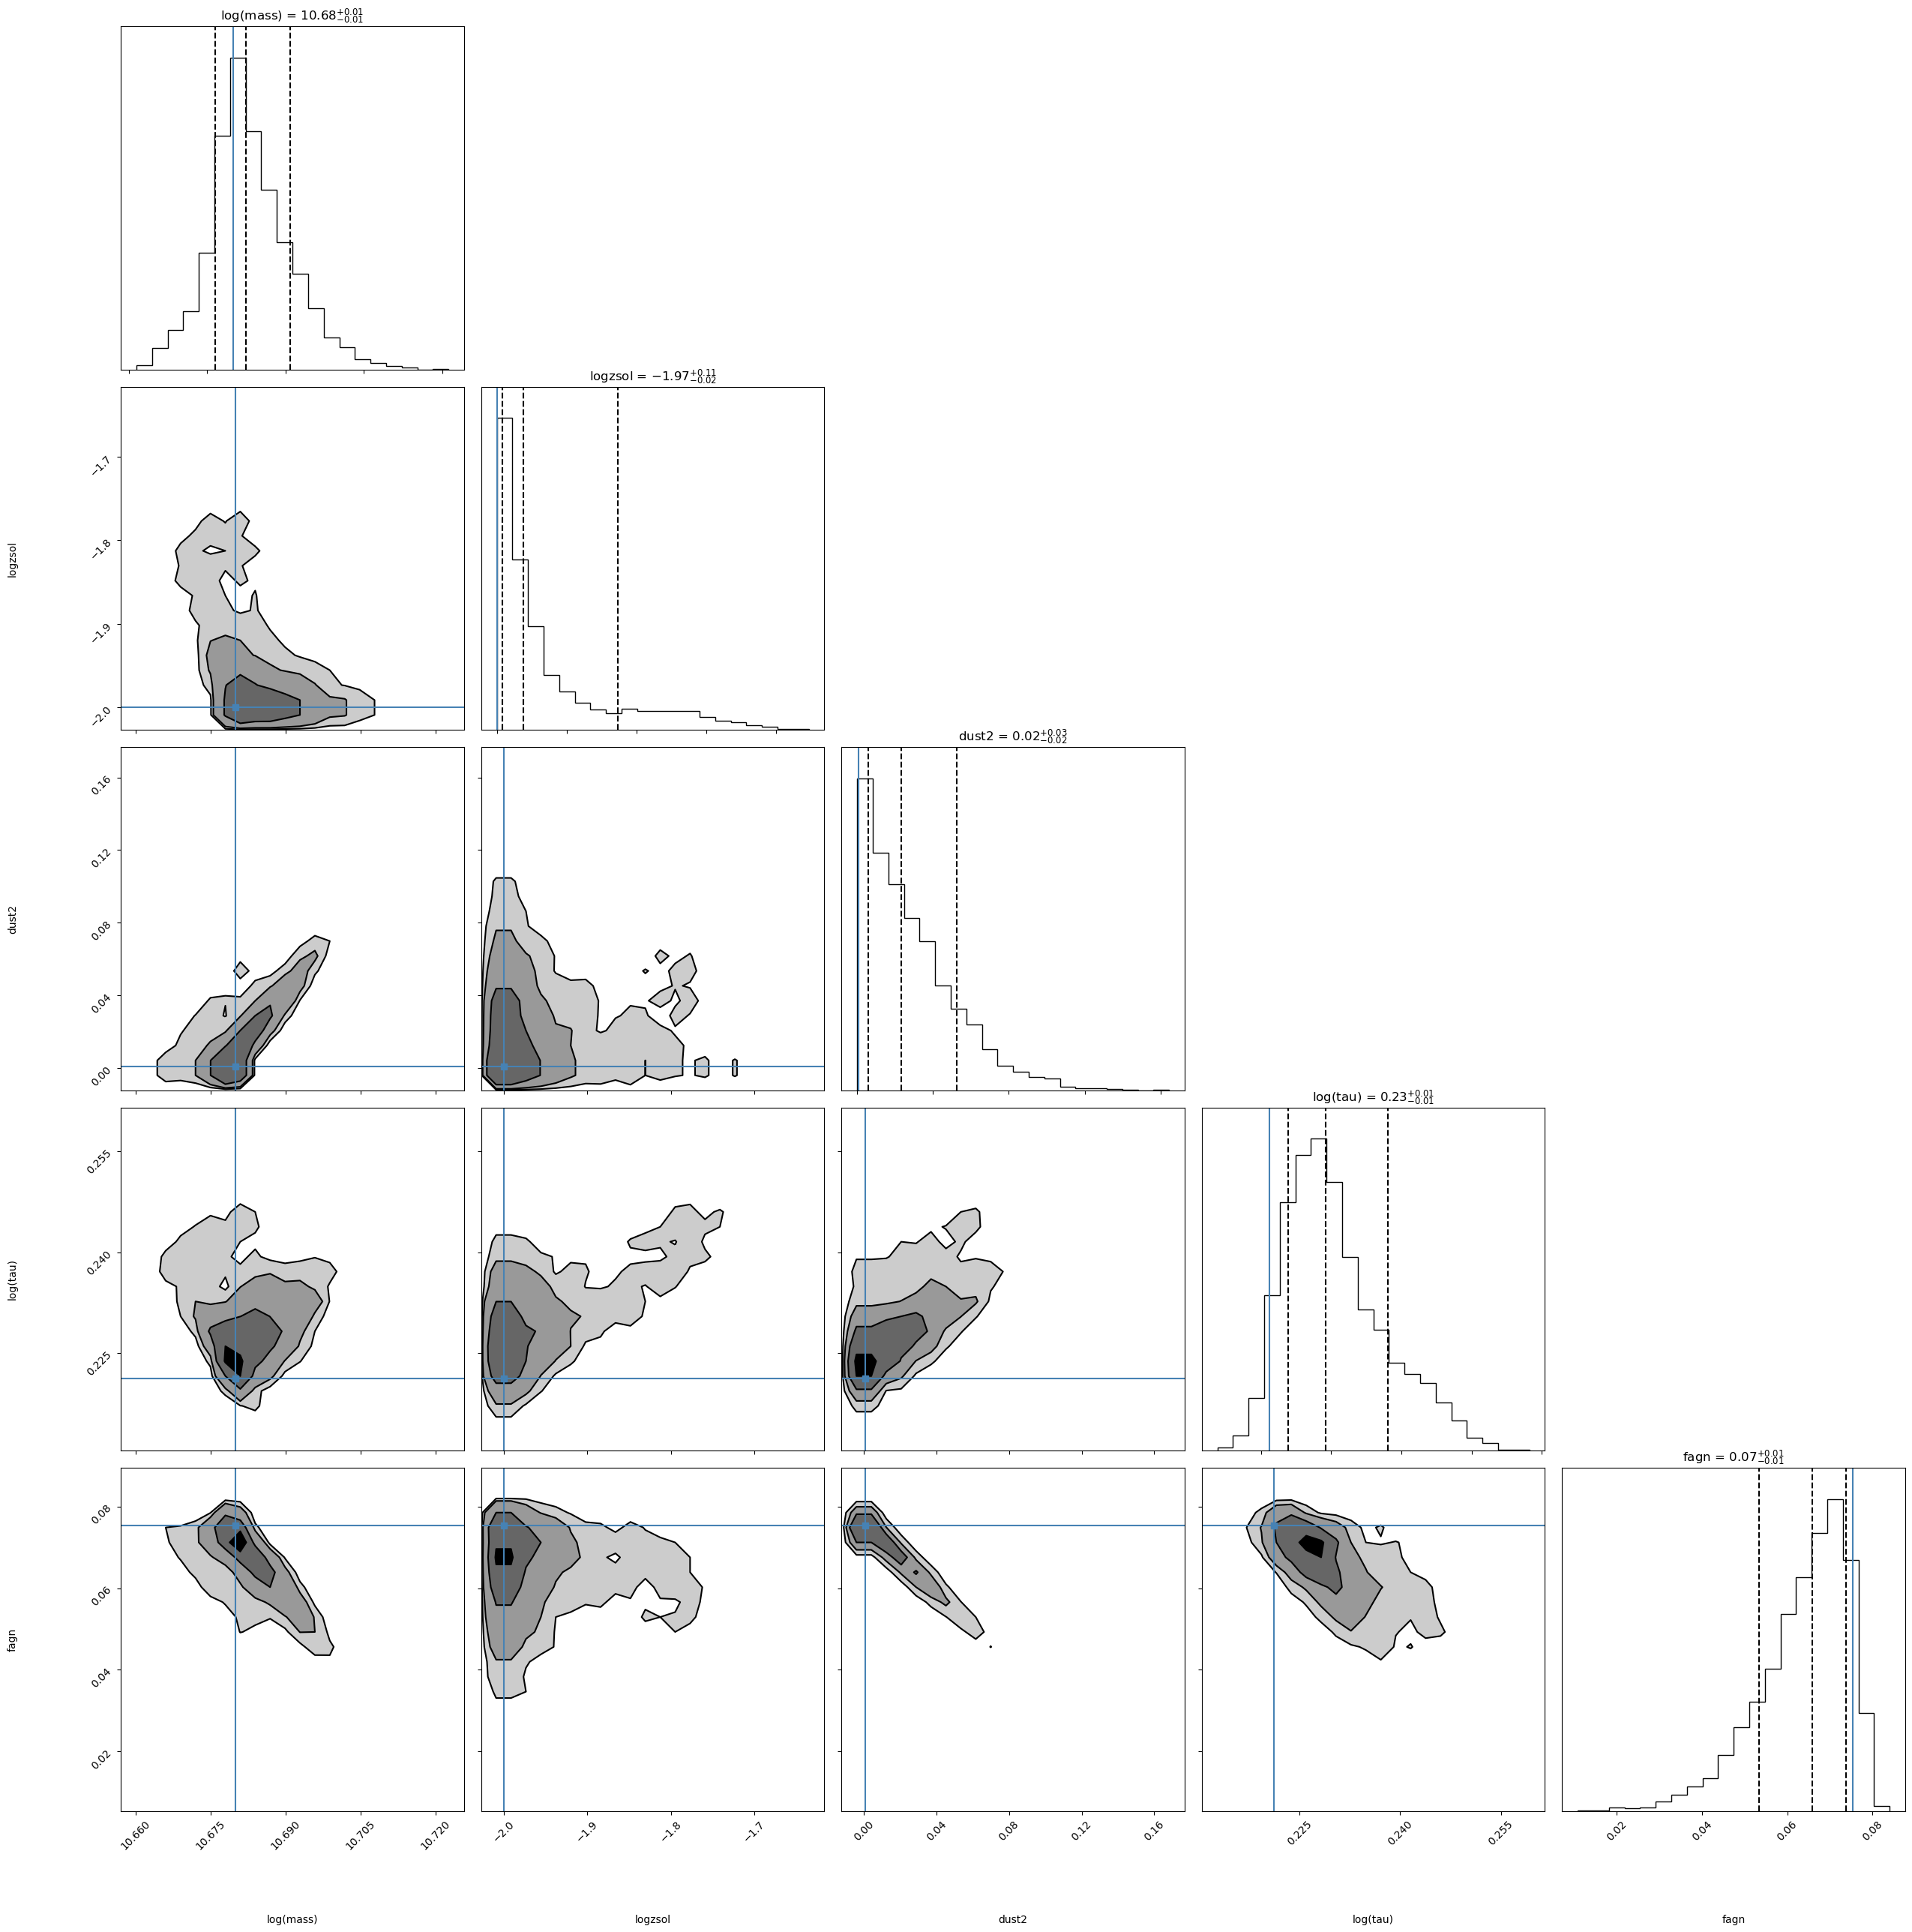

In [49]:

imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    print(result['chain'][i, j, :].copy())
    theta_best = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_best = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_best))
cornerfig = reader.subcorner(result, start=800, thin=thin, truths=theta_best, 
                             fig=plt.subplots(5,5,figsize=(27,27))[0])
#cornerfig = reader.subcorner(result, start=500, thin=thin, truths=theta_best, 
                              #fig=plt.subplots(5,5,figsize=(27,27))[0],range=[(9.152,9.17),(-0.75,-0.55),(0.09,0.12),(0.24,0.285)])

In [50]:
imax = np.argmax(result['lnprobability'])
csz = result["chain"].shape
if result["chain"].ndim > 2:
    # emcee
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
else:
    # dynesty
    theta_max = result['chain'][imax, :].copy()
    flatchain = result["chain"]

# 16th, 50th, and 84th percentiles of the posterior
from prospect.plotting.corner import quantile
weights = result.get("weights", None)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)
print(post_pcts)

[[ 2.34538582e+10  2.34635886e+10  4.80157488e+10]
 [-1.92991743e+00 -7.48311702e-01 -7.12980682e-01]
 [ 1.48343915e-04  5.85290115e-03  7.78699109e-02]
 [ 1.71269146e+00  3.90088580e+00  3.97202732e+00]
 [ 4.24775279e-02  5.88217768e-02  6.60282751e-02]]


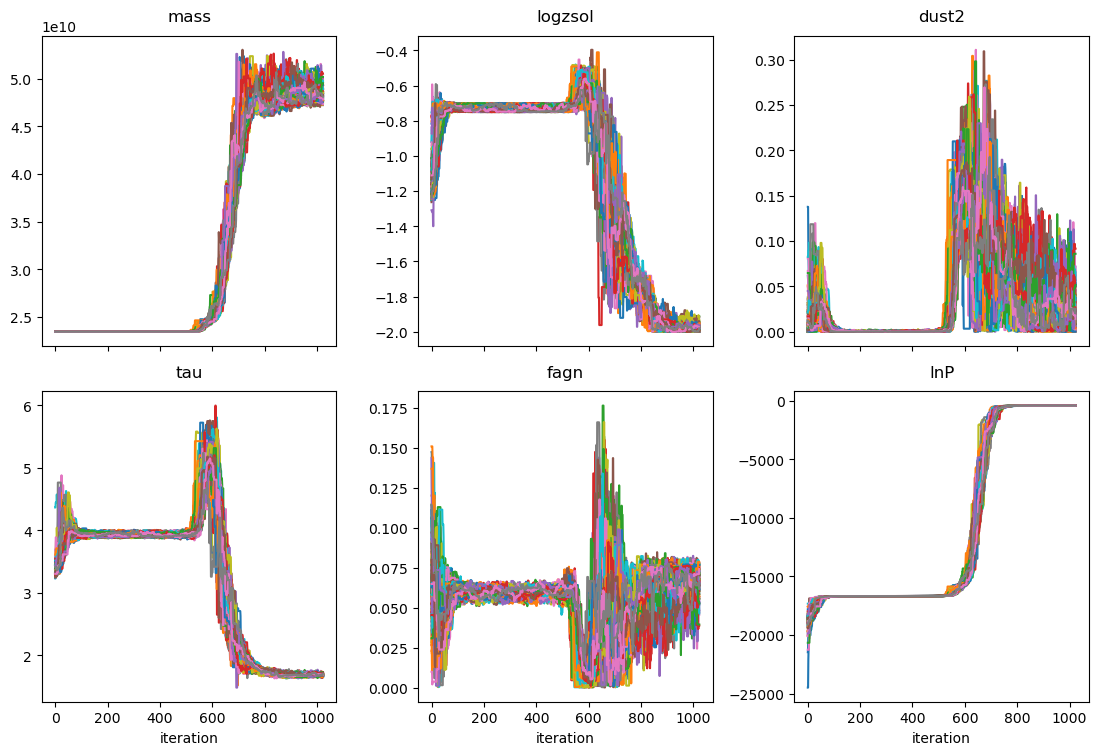

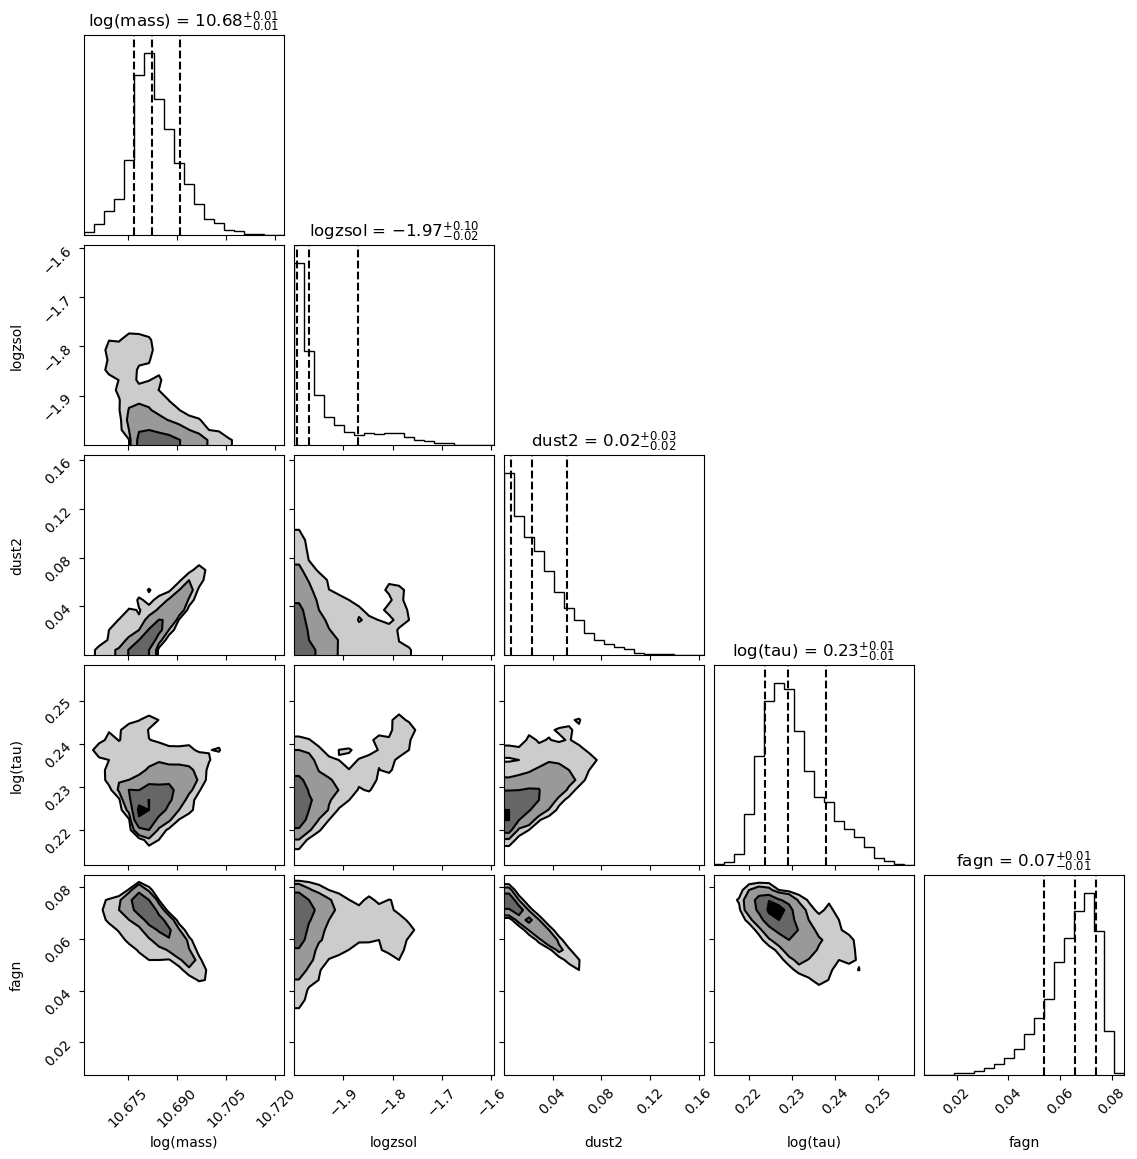

In [62]:
tfig = reader.traceplot(result)
# Corner figure of posterior PDFs
cfig = reader.subcorner(result,start=800)

Text(0, 0.5, '$\\chi_{\\rm best}$')

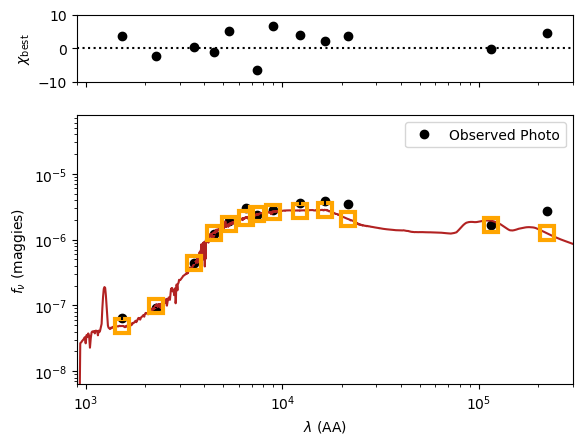

In [60]:
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
mask=np.array([True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True])
ax = saxes[1]
mask=result['obs']['phot_mask']
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave[mask], out_obs["maggies"][mask], linestyle="", marker="o", color="k",label='Observed Photo')
#ax.plot(obs['wavelength'],obs['spectrum']*obs['wavelength'])
ax.errorbar(pwave[mask],  out_obs["maggies"][mask], out_obs["maggies_unc"][mask], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(9e2, 3e5)
ax.set_ylim(np.nanmin(out_obs["maggies"]) * 0.1, np.nanmax(out_obs["maggies"]) * 20)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave[mask], bsed["photometry"][mask], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")
ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave[mask], chi[mask], linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-10, 10)
ax.set_ylabel(r"$\chi_{\rm best}$")

In [63]:
#print(result['model_params'][['name'])
print(result['obs']['phot_mask'])
print([el['name'] for el in result['model_params']])
print(theta_best)

[ True  True  True  True  True  True  True  True  True  True  True False
 False  True  True False False]
['zred', 'mass', 'logzsol', 'dust2', 'sfh', 'tage', 'imf_type', 'dust_type', 'tau', 'add_neb_emission', 'add_neb_continuum', 'nebemlineinspec', 'gas_logz', 'gas_logu', 'fagn', 'agn_tau', 'add_agn_dust']
[ 4.78536313e+10 -1.99949682e+00  9.21360900e-04  1.66416338e+00
  7.53483734e-02]


In [44]:
test_params={'mass': 2.36107653e+10,'logzsol':-4.54441198e-01\
    ,'dust2':3.65821211e-02,'tau':1.79706162e+00,'tage':12.8,'sfh':4}
pset=parametric_pset()
print(pset.mass)
pset.mass=np.array([2.36107653e+10])
pset.tage=np.array([12.8])
pset.tau=np.array([1.79706162e+00])
print(pset)
print(compute_mass_formed([el for el in range(0,15)],pset))


[1.]
Namespace(mass=array([2.36107653e+10]), sfh=4.0, sf_start=array([0]), tage=array([12.8]), tau=array([1.79706162]), const=array([0.]), fburst=array([0.]), tburst=array([1.]), sf_trunc=array([0]), sf_slope=array([0.]))
(array([0.        , 4.21861137, 4.83648999, 4.15864962, 3.1784973 ,
       2.2775223 , 1.56665967, 1.04773688, 0.68639634, 0.44264775,
       0.2819334 , 0.17777472, 0.11117044, 0.06903705, 0.04261845]), array([0.00000000e+00, 2.56165314e+09, 7.26544520e+09, 1.18164302e+10,
       1.54883303e+10, 1.82026019e+10, 2.01078494e+10, 2.14002516e+10,
       2.22558896e+10, 2.28121712e+10, 2.31687697e+10, 2.33948057e+10,
       2.35367715e+10, 2.36252559e+10, 2.36800508e+10]))


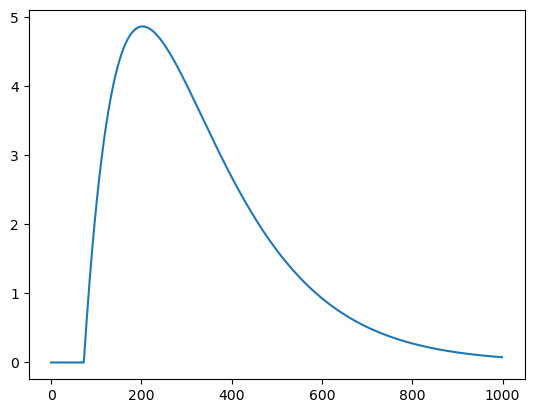

In [45]:
res_params={'mass': np.array([2.36107653e+10]),'logzsol':np.array([-4.54441198e-01])\
    ,'dust2':np.array([3.65821211e-02]),'tau':np.array([1.79706162e+00]),'tage':np.array([12.8]),'sfh':4}

plt.plot(parametric_sfr(times=[el for el in np.linspace(13.8,0,1000)],tavg=0,**res_params))
#print(params_to_sfh(res_params,times=[0]))